In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'float8_e4m3b11fnuz' from 'tensorflow.python.framework.dtypes' (c:\Users\HARSH\anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py)

### Create Dataset

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionResNetV2

# Base model
base_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze feature extractor

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # ✅ binary classification
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',   # ✅ matches sigmoid
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,730,465 (208.78 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
# load caltech101 from TFDS
(train_ds, test_ds), info = tfds.load(
    "caltech101",
    as_supervised=False,
   split = ['train[:80%]', 'train[80%:100%]'],
    with_info=True
)

In [ ]:
# Define pixelation function
def pixelate_tf(image, pixel_size=8):
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    img = tf.image.resize(image, [h // pixel_size, w // pixel_size], method="bilinear")
    img = tf.image.resize(img, [h, w], method="nearest")
    return img

In [ ]:
def make_detection_dataset(ds):
    PIXEL_SIZES = tf.constant([2, 4, 8, 16, 30]) # Define PIXEL_SIZES within the function scope
    def process(sample):
        image = sample["image"]
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

        # Randomly choose to keep or pixelate
        choice = tf.random.uniform([], 0, 1)
        if choice > 0.5:
            pixel_size = tf.random.shuffle(PIXEL_SIZES)[0]
            image = pixelate_tf(image, pixel_size)
            label = tf.constant(1.0)  # pixelated
        else:
            label = tf.constant(0.0)  # clean
        return image, label

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_detection_ds = make_detection_dataset(train_ds)
test_detection_ds = make_detection_dataset(test_ds)

In [ ]:
def expand_dataset(ds, num_copies=3):
    expanded = ds
    for _ in range(num_copies - 1):
        expanded = expanded.concatenate(ds)
    return expanded
train_detection_ds = expand_dataset(train_detection_ds,20)
test_detection_ds = expand_dataset(test_detection_ds,20)

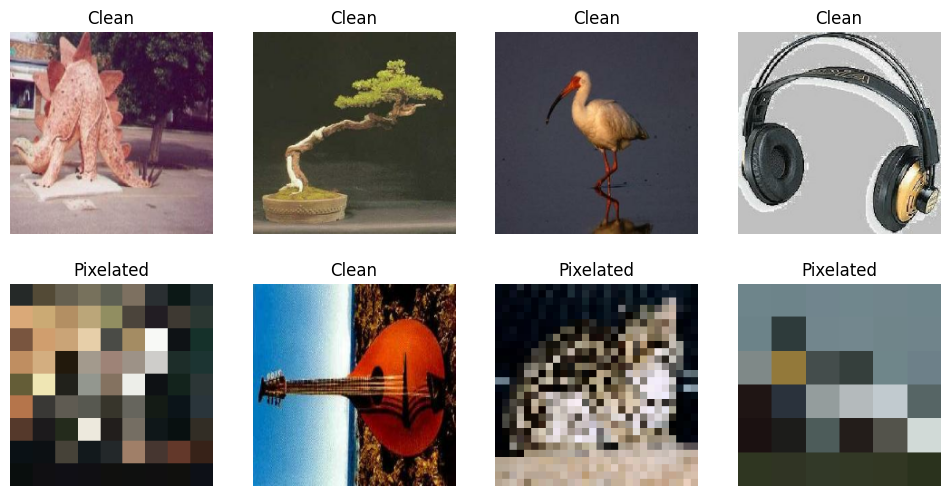

In [ ]:
def show_samples(ds, n=8):
    imgs, labels = next(iter(ds))
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        plt.imshow(imgs[i])
        plt.title("Pixelated" if labels[i] == 1 else "Clean")
        plt.axis("off")
    plt.show()

show_samples(train_detection_ds)

### Data Augmentation

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.05)
])

train_detection_ds = train_detection_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)



In [ ]:
train_detection_ds = train_detection_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_detection_ds = test_detection_ds.prefetch(tf.data.AUTOTUNE)


### Model Building

In [ ]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard
)
import datetime
import os

In [ ]:
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)

In [ ]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath="checkpoints/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
callbacks_list = [checkpoint_cb, earlystop_cb, reduce_lr_cb, tensorboard_cb]

In [ ]:
# print("Train:", train_detection_ds)
# print("Test:", test_detection_ds)

# for x, y in train_detection_ds.take(1):
#     print("X batch:", x.shape, x.dtype)
#     print("Y batch:", y.shape, y.dtype)
#     break


In [ ]:
# count_pixelated = 0
# count_clean = 0
# for _, label_batch in train_detection_ds.unbatch().take(1000):
#     if label_batch.numpy() == 1.0:
#         count_pixelated += 1
#     else:
#         count_clean += 1
# print("Pixelated:", count_pixelated, "Clean:", count_clean)


In [ ]:
from tensorflow.keras import layers, models

def build_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.4),
        layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,801 (1.82 MB)

 Trainable params: 475,841 (1.82 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.fit(
    train_detection_ds,
    validation_data=test_detection_ds,
    epochs=25,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list # Changed callbacks to callbacks_list
)

Epoch 1/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7767 - loss: 0.4677
Epoch 1: val_loss improved from inf to 0.24416, saving model to checkpoints/best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 96s 390ms/step - accuracy: 0.7771 - loss: 0.4671 - val_accuracy: 0.9052 - val_loss: 0.2442 - learning_rate: 1.0000e-04
Epoch 2/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8820 - loss: 0.2839
Epoch 2: val_loss improved from 0.24416 to 0.20918, saving model to checkpoints/best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 251ms/step - accuracy: 0.8820 - loss: 0.2839 - val_accuracy: 0.9265 - val_loss: 0.2092 - learning_rate: 1.0000e-04
Epoch 3/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9092 - loss: 0.2468
Epoch 3: val_loss did not improve from 0.20918
153/153 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9091 - loss: 0.2468 - val_accuracy: 0.9216 - val_loss: 0.2348 - learning_rate: 1.0000e-04
Epoch 4/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - acc

In [ ]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_detection_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9275 - loss: 0.1875
Test Accuracy: 0.9314
Test Loss: 0.1814


In [ ]:
# Save full model (architecture + weights + optimizer state)
model.save("pixel_detection_final_model.keras")

# Or, to save only weights:
model.save_weights("pixel_detection.weights.h5")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
y_true = []
y_pred = []

for images, labels in test_detection_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Classification report
print(classification_report(y_true, y_pred, target_names=["Clean", "Pixelated"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
with open("evaluation_metrics.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


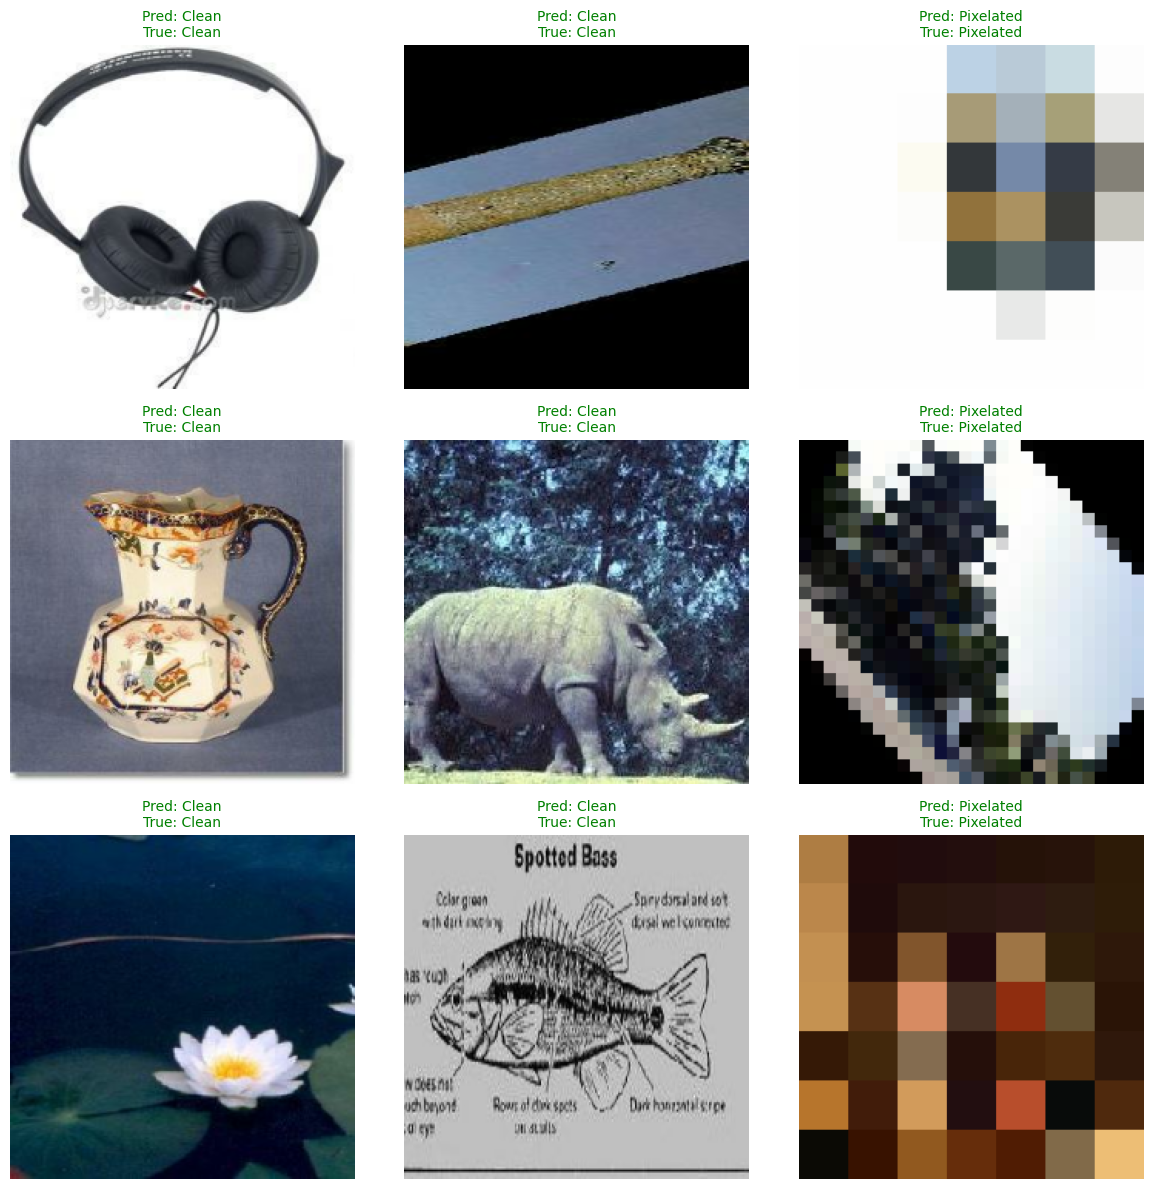

In [ ]:
def visualize_predictions(model, dataset, class_names=["Clean", "Pixelated"], n=9):
    plt.figure(figsize=(12, 12))

    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()

        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())

            true_label = int(labels[i].numpy())
            pred_label = preds[i]

            color = "green" if true_label == pred_label else "red"
            plt.title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                color=color,
                fontsize=10
            )
            plt.axis("off")
    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_detection_ds)
